# Initialization
---
- example data (Heidi 2003 data, 1 day Synechococcus)

In [94]:
#setwd("/Users/ribalet/Documents/DATA/Codes/ssPopModel")
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")

library(seewave) # Kullback-Leibler 
library(DEoptim)
library(cmaes) 

load("inst/extdata/size.distribution_Prochlorococcus") # load observed Prochlorococcus size distribution (from Diel cruise July 2015)

 V.hists <- as.matrix(distribution[[1]][10:35]) # biomass data for 1 day only
 N.dist <- as.matrix(distribution[[2]][10:35]) # size data for 1 day only
 volbins <- rownames(V.hists)
 time <- as.numeric(colnames(V.hists))

Par <- read.csv("inst/extdata/Par.csv")
		Par$time <- as.POSIXct(Par$time, tz="GMT")
        Par[which(Par$par < 0),'par'] <- 0 # remove negative Par values
		id <- which(is.na(Par$par))
			if(length(id) > 0) Par <- Par[-id,] # remove NA in Par

light <- subset(Par, time >= min(time) & time <= max(time))
		pEdata <- smooth.spline(light[,"time"], light[,"par"])
Edata <- as.matrix(cbind(pEdata$x, pEdata$y))


resol <- 10
dt <- resol/60
time.interval <- median(diff(as.numeric(colnames(V.hists))))
ti <- as.numeric(colnames(V.hists))

# create Light data with 'dt' time interval.
seq <- NULL
    for(i in 1:(length(ti)-1)){
		s <- seq(ti[i], ti[i+1], length.out=1/dt)
		seq <- c(seq, s)
		}
ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
Einterp <- ep$y
Einterp[Einterp < 0] <- 0

- Load matrix model

In [11]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- $Sigma$ function for sum of squared residuals
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2


In [106]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
        
                gmax <- as.numeric(params[1]) / 100
                dmax <- as.numeric(params[2]) 
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000
        
			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler divergence
$$
Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [108]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
            
                gmax <- as.numeric(params[1]) / 100
                dmax <- as.numeric(params[2]) * 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


- $Sigma$ function for Huber loss
$$
L =\begin{cases}
\frac12(y - \hat{y})^2 & for |y - \hat{y}| \leq d\\
d|y - \hat{y}| - \frac12 d^2 & otherwise
\end{cases}
$$


In [102]:
###############
## sigma.hl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# using Hubert Loss (1954) approach.

	.sigma.hl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
           
                gmax <- as.numeric(params[1]) / 100
                dmax <- as.numeric(params[2]) 
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

        delta <- 1.345
			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
                    # Huber loss calculation
                    a <- N.dist[, hr+1] - round(TotN[hr+1]*wt.norm,1)
                    loss <- ifelse(abs(a) <= delta,
                                       0.5 * a^2,
                                       delta * (abs(a) - 0.5 * delta))
                    sigma[,hr] <- mean(loss, na.rm=T)
                    }
            sigma <- sum(sigma)/100 ## HUBER loss

			return(sigma)

}

# 1. Objective functions
---

- ### sum of squared residuals 

In [109]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax <- as.numeric(params[1]) / 100
        dmax <- as.numeric(params[2]) * 10
        b <- as.numeric(params[3]) * 10
        E_star <- as.numeric(params[4]) / 1000
		resnorm <- opt$optim$bestval

- ### Kullback-Leibler divergence

In [104]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax. <- as.numeric(params[1]) / 10
        dmax. <- as.numeric(params[2]) / 10
        b. <- as.numeric(params[3]) * 10
        E_star. <- as.numeric(params[4]) * 1000
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.526036 bestmemit:    0.319029    0.001789    0.236051    0.054855
Iteration: 20 bestvalit: 0.467341 bestmemit:    0.999409    0.000347    0.650957    0.169422
Iteration: 30 bestvalit: 0.460736 bestmemit:    0.990561    0.000011    0.177818    0.187521
Iteration: 40 bestvalit: 0.460202 bestmemit:    0.994958    0.000081    0.219303    0.197111
Iteration: 50 bestvalit: 0.460077 bestmemit:    0.997920    0.000090    0.199930    0.194646
Iteration: 60 bestvalit: 0.459967 bestmemit:    0.999103    0.000010    0.319868    0.195435
Iteration: 70 bestvalit: 0.459892 bestmemit:    0.999613    0.000026    0.022991    0.195657
Iteration: 80 bestvalit: 0.459869 bestmemit:    0.999776    0.000015    0.233150    0.195462
Iteration: 90 bestvalit: 0.459865 bestmemit:    0.999837    0.000017    0.167322    0.195792
Iteration: 100 bestvalit: 0.459865 bestmemit:    0.999991    0.000016    0.178850    0.195825
Iteration: 110 bestvalit: 0.459863 bestmemit:    0.999949    0.000020

- ### Huber loss 

In [105]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) / 10
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt$optim$bestval

Iteration: 10 bestvalit: 47.061700 bestmemit:    0.582124    0.007136    0.174404    0.155465
Iteration: 20 bestvalit: 45.436044 bestmemit:    0.946669    0.000633    0.321869    0.200758
Iteration: 30 bestvalit: 45.354958 bestmemit:    0.974261    0.000164    0.275652    0.201455
Iteration: 40 bestvalit: 45.316077 bestmemit:    0.996525    0.000065    0.276998    0.201214
Iteration: 50 bestvalit: 45.294274 bestmemit:    0.999080    0.000061    0.272654    0.197001
Iteration: 60 bestvalit: 45.292639 bestmemit:    0.999912    0.000096    0.258311    0.197484
Iteration: 70 bestvalit: 45.292474 bestmemit:    0.999965    0.000085    0.223304    0.197562
Iteration: 80 bestvalit: 45.292280 bestmemit:    0.999973    0.000078    0.236578    0.196922
Iteration: 90 bestvalit: 45.292136 bestmemit:    0.999980    0.000078    0.234629    0.196879
Iteration: 100 bestvalit: 45.292113 bestmemit:    0.999992    0.000078    0.234629    0.196879
Iteration: 110 bestvalit: 45.292089 bestmemit:    0.999980 

##  Results

In [56]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- Vproj.. <-V.hists
Nproj <- Nproj. <- Nproj.. <- N.dist
mu_N <- mu_N. <- mu_N.. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
          		    
#       B.. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
#       Nproj..[,hr+1] <- round(B.. %*% Nproj..[,hr]) # calculate numbers of individuals
#       Vproj..[,hr+1] <- B.. %*% Vproj..[,hr] # calculate the projected size-frequency distribution
# 	    Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
# 		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
# 					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)
Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2),"-",round(d.mu_N..,2)))

[1] "daily growth rate= 0.13 - 0 - NaN"


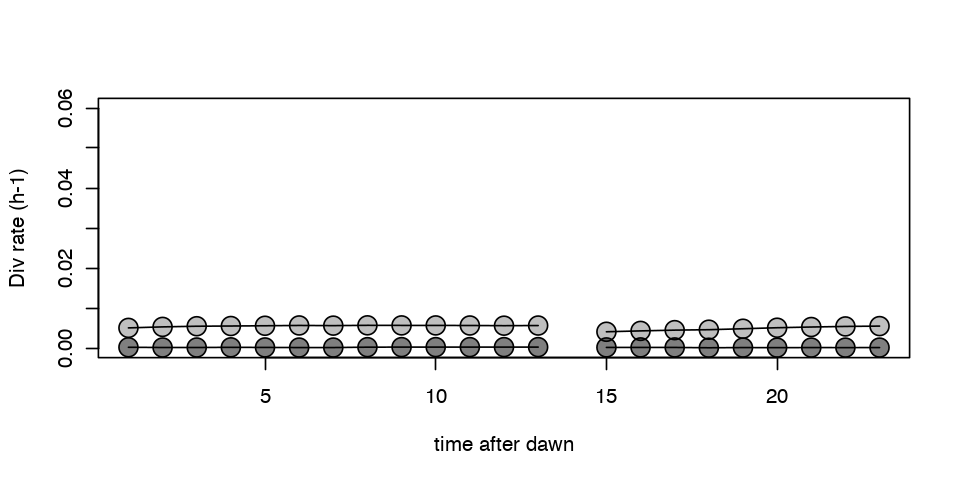

In [57]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
    points(mu_N..[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.75))

No id variables; using all as measure variables
ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'Var2' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mi

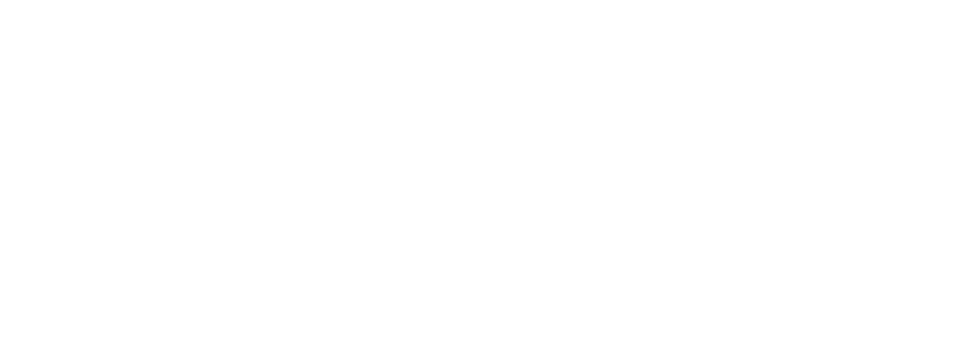

In [59]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
# ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
# ggplot(melt(Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
# ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

In [ ]:
ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj.-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Objective functions
---

- ### Differential evolution

In [ ]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(0,0,0,0), upper=c(1,1,1,1), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
        gmax.. <- as.numeric(params[1]) / 50
        dmax.. <- as.numeric(params[2]) / 50
        b.. <- as.numeric(params[3]) * 50
        E_star.. <- as.numeric(params[4]) * 5000
		resnorm.. <- opt$optim$bestval

- ### Covariance matrix adapting evolutionary strategy

In [ ]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt$par
        gmax... <- as.numeric(params[1]) / 50
        dmax... <- as.numeric(params[2]) / 50
        b... <- as.numeric(params[3]) * 50
        E_star... <- as.numeric(params[4]) * 5000
		resnorm... <- opt$value
print(params)

##  Results

In [ ]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj.. <- Vproj... <-V.hists
Nproj.. <- Nproj... <- N.dist
mu_N.. <- mu_N... <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
        Nproj..[,hr+1] <- round(B %*% Nproj..[,hr]) # calculate numbers of individuals
	    Vproj..[,hr+1] <- B %*% Vproj..[,hr] # calculate the projected size-frequency distribution
		Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
		mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					    ((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax..., dmax=dmax...,b=b..., E_star=E_star..., resol=resol)
      Nproj...[,hr+1] <- round(B. %*% Nproj...[,hr]) # calculate numbers of individuals
      Vproj...[,hr+1] <- B. %*% Vproj...[,hr] # calculate the projected size-frequency distribution
	    Vproj...[,hr+1] <- Vproj...[,hr+1]/sum(Vproj...[,hr+1]) # normalize distribution so sum = 1
		mu_N...[,hr+1] <- log(sum(Nproj...[,hr+1])/sum(Nproj...[,hr]))/
					    ((as.numeric(colnames(Nproj...)[hr+1])-as.numeric(colnames(Nproj...)[hr]))/(time.interval))				
    }

Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)
Nproj... <- colSums(Nproj...)
colnames(mu_N...) <- colnames(Vproj...)
#############################
## Growth rate calculation ##
#############################
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)
d.mu_N... <- 24*mean(mu_N...[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N..,2),"-",round(d.mu_N...,2)))

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N..[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N...[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))


In [ ]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj...), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

In [ ]:
ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj..-V.hists)))

ggplot(melt(Vproj...-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
print(mean(abs(Vproj...-V.hists)))

ggplot(melt(Vproj...-Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='green3',high='brown', midpoint=0)
print(mean(abs(Vproj...-Vproj..)))